# Example code to predict future extreme significant wave heights globally

CSIRO 2021-05-21

Based on the change factor downscalling analysis presented in:

O’Grady, J.G., Hemer, M.A., McInnes, K.L. et al. Projected incremental changes to extreme wind-driven wave heights for the twenty-first century. Sci Rep 11, 8826 (2021). https://doi.org/10.1038/s41598-021-87358-w


In [1]:
#required modules for Python 3
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np


In [2]:
#online data
threddsdir =  "https://data-cbr.csiro.au//thredds/dodsC/catch_all/OA_SLE_archive/COWCLIP/EXTREMES/EVA_R/CSIRO_withMidCentury/"

In [3]:
#read in the netcdf files
GEVparam = xr.open_dataset(threddsdir+"CAWCR_GEVparameters.nc")
dHm0_rcp85 = xr.open_dataset(threddsdir+"dHm0_rcp85_Ensemble_stats.nc")
GEVparam

<xarray.Dataset>
Dimensions:        (Latitude: 160, Longitude: 360, Parameter: 3)
Coordinates:
  * Longitude      (Longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * Latitude       (Latitude) float64 79.54 78.54 77.54 ... -77.46 -78.46 -79.46
  * Parameter      (Parameter) int32 1 2 3
Data variables:
    crs            int32 ...
    GEVparameters  (Parameter, Latitude, Longitude) float32 ...
Attributes:
    Conventions:                     CF-1.7
    created_by:                      R, packages ncdf4 and raster (version 3....
    date:                            2021-05-17 16:14:56
    creator_name:                    Julian O'Grady CSIRO
    creator_email:                   julian.ogrady@csiro.au
    reference:                       https://doi.org/10.1038/s41598-021-87358-w
    title:                           O�Grady, J.G., Hemer, M.A., McInnes, K.L...
    summary:                         GEV parameters (1=location, 2=scale, 3=s...
    keywords:                        COWCL

In [4]:
#WE STRONGLY RECOMMEND USING YOUR OWN GEV PARAMETERS FITTED TO BUOY DATA, OR A CALIBRATED HINDCAST
GEVparam.Disclaimer

'The data available in this file are generated through numerical modelling performed by CSIRO based on a range of input datasets to help communicate risks associated with future changes to wind-waves. All information and data found in this file was generated for research purposes. While every effort has been made to ensure data accuracy, the developers make no warranty (expressed or implied) regarding accuracy, completeness, function or capability of the file and associated data. The data is not provided as professional advice, and the user assumes any risk associated with use, possession or reliance on content for decision making. The developers expressly disclaim liability for any loss arising from use of this file and the information contained therein. The models incorporated here are general in nature and more detailed studies may be required for individual regions'

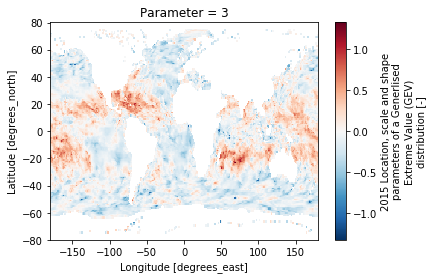

In [5]:
#plot a map of the CAWCR hindcast GEV shape parameter
GEVparam.GEVparameters[2].plot()
plt.show()


In [6]:
#function to compute the return level (RL) from a generalised extreme value (GEV) distribution
def GEV_RL(AEP,location,scale,shape):
    RL = location + (scale * ((-np.log(1. - AEP))**(-shape) - 1.))/shape
    return RL


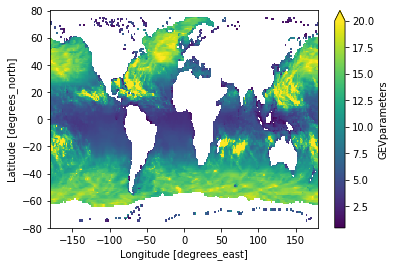

In [7]:
# estimate the 1 in 100 year ARI ( = 1% AEP)
ARI = 100 #Average Return Interval
AEP = 0.01 #Annual Exceedance Probability
RL_2015 = GEV_RL(AEP,GEVparam.GEVparameters[0],GEVparam.GEVparameters[1],GEVparam.GEVparameters[2])
RL_2015.plot(vmax= 20)
plt.show()

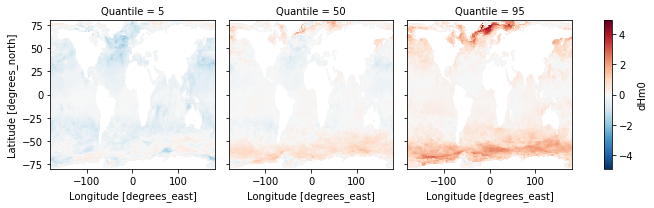

In [8]:
#plot the incremental change from the base year 2015 to the year 2100 for the rcp8.5 scinario
#quantiles correspond to the low end (5) mid (50) and high end estimates of the 8 GWCM ensemble

nyrs = (2100.-2015.)
dRL_2100 = dHm0_rcp85.dHm0*nyrs
dRL_2100.plot(x ="Longitude",y="Latitude",col="Quantile")
plt.show()

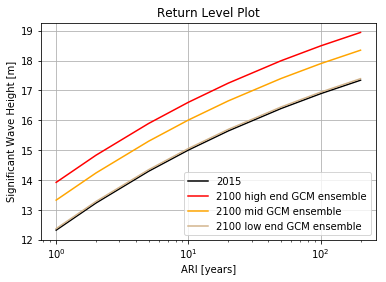

In [9]:
#plot ARI Return Level curve for a given point (ilon,ilat)
ARI = np.array([1,2,5,10,20,50,100,200]) #Average exceedence interval [years]
AEP =  AEP = 1-np.exp(-1.0/ARI) #Annual Exceedence probablity

#select a lat and long point
ilon = 100.0
ilat = -55.0

#linear interpolated gridded data to ilon, ilat point
iGEV = GEVparam.GEVparameters.interp(Longitude=ilon, Latitude=ilat, method="linear")

#compute the RLs for different AEPs
RL_2015 = GEV_RL(AEP,iGEV[0].data,iGEV[1].data,iGEV[2].data)

#linear interpolated gridded data to ilon, ilat point
dHm0_rcp85_to2100 = dHm0_rcp85.dHm0.interp(Longitude=ilon, Latitude=ilat, method="linear")

#downscale the climate to 2100 by added a change factor
#add the incremental change (dHm0) multipled by the number of years from 2015 to the 2100 RL.
nyrs = (2100.-2015.)
RL_2100_low = RL_2015+dHm0_rcp85_to2100[0].data*nyrs
RL_2100_mid = RL_2015+dHm0_rcp85_to2100[1].data*nyrs
RL_2100_high = RL_2015+dHm0_rcp85_to2100[2].data*nyrs

plt.plot(ARI,RL_2015, label="2015",color="black")
plt.plot(ARI,RL_2100_high, label="2100 high end GCM ensemble",color="red")
plt.plot(ARI,RL_2100_mid, label="2100 mid GCM ensemble",color="orange")
plt.plot(ARI,RL_2100_low, label="2100 low end GCM ensemble",color="tan")
plt.legend()
plt.grid()
plt.xscale('log')
plt.ylabel("Significant Wave Height [m]")
plt.xlabel("ARI [years]")
plt.title("Return Level Plot")
plt.show()